# Using Future Data As A Test Set
### Model #1: (Classification - Fully Paid vs. Default) 
### Model #2: ( Regression - Annualized Return %)

In [66]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_LC_data_classification_eval,preprocessing_eval,
                                   preprocessing_future_test, 
                                   columns_list, nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_current, one_hot_encode_future, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification)
from functions_and_objects import (prep_df_for_regression_current,
                                   calc_annu_return,impute_annu_return_to_y,
                                   scale_current)
from functions_and_objects import (regression_model_eval_prep_pipeline,
                                   classification_model_eval_prep_pipeline,
                                   clean_new_LC_data_classification_current,
                                  preprocessing_current)
                                   

import joblib
from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import New Data from 2018-2019

In [2]:
raw_q12019 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2019Q1.csv',header=1)
raw_q42018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q4.csv',header=1)
raw_q32018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q3.csv',header=1)
raw_q22018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q2.csv',header=1)
raw_q12018 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2018Q1.csv',header=1)
dfs_list = [raw_q42018,
            raw_q32018,
            raw_q22018,
            raw_q12018]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,129,130,131,134,135,136,139,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
clean_lc_df_eval = clean_LC_data_classification_eval(dfs_list)
X_train, X_test, y_train_classif, y_test_classif = preprocessing_eval(clean_lc_df_eval)
(ohe_home_ownership, ohe_purpose, ohe_zip_code, ohe_application_type, ohe_sub_grade, ohe_emp_title_2,
ohe_home_ownership_test, ohe_purpose_test, ohe_zip_code_test, ohe_application_type_test, 
ohe_sub_grade_test, ohe_emp_title_2_test) = one_hot_encode_future(X_train, X_test)
X_train_classif = concat_X_and_6ohe_dfs(X_train, ohe_home_ownership, ohe_purpose, ohe_zip_code, 
                                        ohe_application_type, ohe_sub_grade, ohe_emp_title_2)
X_test_classif = concat_X_and_6ohe_dfs(X_test, ohe_home_ownership_test, ohe_purpose_test, ohe_zip_code_test, 
                                       ohe_application_type_test, ohe_sub_grade_test, ohe_emp_title_2_test)
prep_all_df_for_classification(X_train_classif)#drops columns in place
prep_all_df_for_classification(X_test_classif)#drops columns in place

/home/jupyter/peervest/functions_and_objects.py:243: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/jupyter/peervest/functions_and_objects.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[col] = X_train[col].fillna(0.0)
/home/jupyter/peervest/functions_and_objects.py:197: Setti

In [11]:
print(X_train_classif.shape)
print(y_train_classif.shape)
print(X_test_classif.shape)
print(y_test_classif.shape)

(47310, 1108)
(47310, 1)
(20276, 1108)
(20276, 1)


### Concatenate train & test to create X_future_classif & y_future_classif

In [12]:
X_future_classif = pd.concat([X_train_classif,X_test_classif])
y_future_classif = pd.concat([y_train_classif,y_test_classif])

### Scaling X_future_classif

In [15]:
ss = StandardScaler()
X_future_classif_s = ss.fit_transform(X_future_classif)

### Prep Data Types for Eval

In [50]:
X_future_classif_s = X_future_classif_s.astype('float32')
y_future_classif['loan_status'] = y_future_classif['loan_status'].astype(int)

### X_train_classif_s for FUTURE data is ready to input into Classification Model

###### Load Classification Model JobLib

In [17]:
loaded_nn_v7 = joblib.load('nn_v7.joblib')

Using TensorFlow backend.
W0708 05:52:10.740142 140249019799296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 05:52:10.759979 140249019799296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 05:52:10.859142 140249019799296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 05:52:10.861079 140249019799296 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0708 05:52:10.86

In [51]:
future_class_preds = loaded_nn_v7.predict_classes(X_future_classif_s)
future_class_preds_proba = loaded_nn_v7.predict_proba(X_future_classif_s)

In [52]:
future_class_preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [53]:
np.array(y_future_classif['loan_status'])

array([1, 1, 1, ..., 1, 1, 1])

In [54]:
future_class_preds_proba

array([[0.9944047 ],
       [0.9894718 ],
       [0.99465525],
       ...,
       [0.9920673 ],
       [0.99418133],
       [0.9947019 ]], dtype=float32)

In [58]:
print ("Precision Fully Paid: {}".format(precision_score(y_future_classif,future_class_preds)))
print ("Recall Fully Paid: {}".format(recall_score(y_future_classif,future_class_preds)))
print ("F-1 Score Fully Paid: {}".format(f1_score(y_future_classif,future_class_preds)))
print ("ROC-AUC Score: {}".format(roc_auc_score(y_future_classif,future_class_preds)))

Precision Fully Paid: 0.9984643897272968
Recall Fully Paid: 0.9977247473411291
F-1 Score Fully Paid: 0.9980944315053991
ROC-AUC Score: 0.9948675164752299


In [59]:
#precision, recall, f1-score
print ("Precision, Recall, F, & Support By Class [0,1] aka [Default,Fully Paid]: {}".format(
    precision_recall_fscore_support(y_future_classif,future_class_preds)))

print ("Precision, Recall, F, & Support Weighted Average by Support: {}".format(
    precision_recall_fscore_support(y_future_classif,future_class_preds,average='weighted')))

Precision, Recall, F, & Support By Class [0,1] aka [Default,Fully Paid]: (array([0.9881987 , 0.99846439]), array([0.99201029, 0.99772475]), array([0.99010082, 0.99809443]), array([10889, 56697]))
Precision, Recall, F, & Support Weighted Average by Support: (0.9968104512610447, 0.9968040718491995, 0.9968065555845598, None)


(array([1.0355e+04, 2.1700e+02, 8.2000e+01, 4.5000e+01, 4.0000e+01,
        2.6000e+01, 2.1000e+01, 1.7000e+01, 2.0000e+01, 1.2000e+01,
        1.4000e+01, 2.4000e+01, 2.0000e+01, 1.7000e+01, 2.1000e+01,
        2.1000e+01, 2.2000e+01, 1.5000e+01, 2.7000e+01, 3.4000e+01,
        3.2000e+01, 4.5000e+01, 4.0000e+01, 6.5000e+01, 9.9000e+01,
        1.4000e+02, 2.0700e+02, 4.2000e+02, 1.3450e+03, 5.4143e+04]),
 array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
        0.16666667, 0.2       , 0.23333333, 0.26666668, 0.3       ,
        0.33333334, 0.36666667, 0.4       , 0.43333334, 0.46666667,
        0.5       , 0.53333336, 0.56666666, 0.6       , 0.6333333 ,
        0.6666667 , 0.7       , 0.73333335, 0.76666665, 0.8       ,
        0.8333333 , 0.8666667 , 0.9       , 0.93333334, 0.96666664,
        1.        ], dtype=float32),
 <a list of 30 Patch objects>)

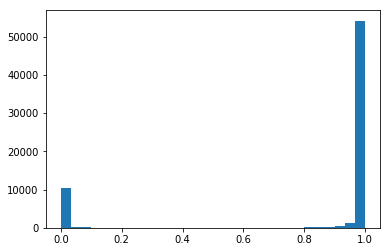

In [61]:
plt.hist(future_class_preds_proba,bins=30,range=(0,1))

(array([ 39.,  30.,  27.,  22.,  14.,  13.,  16.,   9.,  16.,   9.,  17.,
         17.,  15.,  14.,  19.,  17.,  16.,  16.,  13.,  23.,  26.,  33.,
         24.,  33.,  35.,  48.,  76.,  93., 117., 177.]),
 array([0.1       , 0.12666667, 0.15333334, 0.18      , 0.20666666,
        0.23333333, 0.26      , 0.28666666, 0.31333333, 0.34      ,
        0.36666667, 0.39333335, 0.42      , 0.44666666, 0.47333333,
        0.5       , 0.52666664, 0.55333334, 0.58      , 0.6066667 ,
        0.6333333 , 0.66      , 0.68666667, 0.7133333 , 0.74      ,
        0.76666665, 0.79333335, 0.82      , 0.8466667 , 0.87333333,
        0.9       ], dtype=float32),
 <a list of 30 Patch objects>)

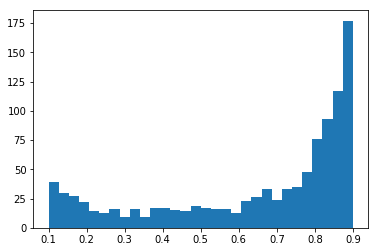

In [63]:
plt.hist(future_class_preds_proba,bins=30,range=(0.1,0.9))

### ROC Curve nn_v7 - Future Data

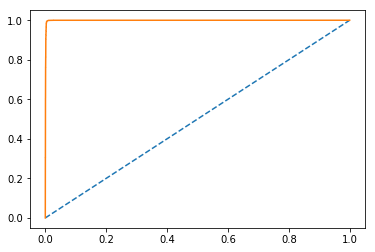

In [64]:
# keep probabilities for the positive outcome only
probs = future_class_preds_proba
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_future_classif, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()

### Probability Calibration nn_v7 - Future Data

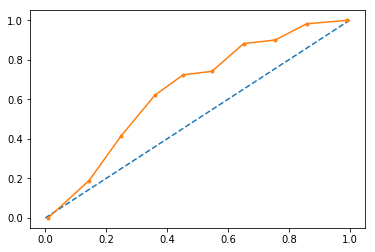

In [68]:
# reliability diagram
fop, mpv = calibration_curve(y_future_classif, future_class_preds_proba, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

### Prep X_future for Regression

- reset index

In [ ]:
X_future_regr.set_index('index',inplace=True)

- calculate annual return & create new target dataframe

In [ ]:
# returns the annualized return column as a DF (y_future_regr) & both target columns as a dataframe (y_future)
y_future_regr, y_future = impute_annu_return_to_y(X_future_regr,y_future)

- drop non-numeric & OHE source columns

In [ ]:
prep_df_for_regression_current(X_future_regr)

In [ ]:
X_future_regr_scaled = scale_current(X_future_regr)

###### Load Ridge Regression Model JobLib

In [ ]:
loaded_ridge_reg_v1 = joblib.load('ridge_lin_reg_v1.joblib')

In [ ]:
future_return_preds = loaded_ridge_reg_v1.predict(X_future_regr_scaled)

### Evaluate Regression Model - No Filter/All Completed Loans

In [ ]:
print("FUTURE TEST - ERROR METRICS:")
print("R-Squared: {}".format(r2_score(y_future_regr, future_return_preds)))
print("Mean Squared Error: {}".format(mean_squared_error(y_future_regr, future_return_preds)))
print("Root Mean Squared Error: {}".format(sqrt(mean_squared_error(y_future_regr, future_return_preds))))

### Conclusion:
- My Logistic Classification Model is generalizable with future data 
- My Ridge Regression Model is also generalizable with future data
- The Regression Model performs worse when you filter out by Probability of Default, though it will be more useful to train a model like that first

##### Extra Scratch Work

### Evaluate Regression Model - Probability of Default Filter

In [ ]:
y_future_regr['prob_default'] = future_class_preds_proba[:,0].reshape(-1,1)

In [ ]:
#Add Predicted Probability of Default column to X_future_regr
future_return_preds_def = pd.DataFrame(np.hstack((future_return_preds,future_class_preds_proba[:,0].reshape(-1,1))),
                                       index=X_future_regr_scaled.index,
                                       columns=['annu_return','prob_default'])

In [ ]:
future_return_preds_filter = future_return_preds_def['annu_return'][future_return_preds_def['prob_default'] < 0.3]
y_future_regr_filter = y_future_regr['annu_return'][y_future_regr['prob_default'] < 0.3]

In [ ]:
print("FUTURE TEST - ERROR METRICS - PROBABILITY of DEFAULT FILTER taking < 0.3:")
print("R-Squared: {}".format(r2_score(y_future_regr_filter, future_return_preds_filter)))
print("Mean Squared Error: {}".format(mean_squared_error(y_future_regr_filter, future_return_preds_filter)))
print("Root Mean Squared Error: {}".format(sqrt(mean_squared_error(y_future_regr_filter, future_return_preds_filter))))

In [ ]:
y_future[y_future['loan_status'] == 0].sort_values(by='annu_return',ascending=False).head(22)

- Positive annu_return values where loan_status==0 likely indicates a successful debt collection process